In [28]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import sys

import pickle
import argparse

import random, string

In [29]:
import os

machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner

In [30]:
print('PyRedner location: %s'%pyredner.__file__)

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset_name', type = str, required = True)
# parser.add_argument('--model_files_pickle_name', type = str, required = True)
# args = parser.parse_args()

# DATASET_NAME = args.dataset_name
# MODEL_FILES_PICKLE_NAME = args.model_files_pickle_name

DATASET_NAME = "train_v5_shapenet"
MODEL_FILES_PICKLE_NAME = "categories_10_models_10.pkl"

SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)
model_files_pickle_path = '%s/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%(user_root_dir, MODEL_FILES_PICKLE_NAME)

if not os.path.isdir(dataset_path):
    print('This is a new dataset, creating a new folder at: %s'%dataset_path)
    os.mkdir(dataset_path)

PyRedner location: /net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [31]:
RADIUS_MIN = 5.0
RADIUS_MAX = 8.0 
MAX_NUM_LIGHTS = 3

RADIUS_MIN_CAM = 0.5
RADIUS_MAX_CAM = 6.0

In [32]:
def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = list(radius*vector/np.linalg.norm(vector))
        points.append(point)
    return points

In [33]:
def get_light_positions(max_num_lights, radius_min, radius_max):
    if max_num_lights == 1:
        num_lights = 1
    else:
        num_lights = random.choice(range(1,max_num_lights+1))
    light_positions = []
    
    for num in range(num_lights):
        random_radius = random.uniform(radius_min, radius_max)
        light_point = generate_uniform_on_sphere(1, random_radius)[0]
        light_point = torch.tensor(light_point).float()
        light_positions.append(light_point)
    
    return light_positions

In [34]:
def get_camera_position(light_positions):
    smallest_radius = 10000
    for light_position in light_positions:
        x, y, z = light_position
        radius = np.sqrt(x**2 + y**2 + z**2)
        if radius < smallest_radius:
            smallest_radius = radius
    
    camera_pos = generate_uniform_on_sphere(1, smallest_radius * random.uniform(0.6,0.9))
    return torch.tensor(camera_pos)

In [35]:
def get_random_intensity():
    light_intensity = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)]).float()
    return light_intensity

In [36]:
def get_random_reflectance():
    specular_reflectance = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)], device = pyredner.get_device()).float()
    return specular_reflectance

In [66]:
def plane_object():
    mat = pyredner.Material(diffuse_reflectance = get_random_reflectance(), two_sided = True)
    
    plane = pyredner.Object(vertices = torch.tensor([[-1.0,-1.0, 1.0],
                                                 [-1.0, 1.0, 2.0],
                                                 [ 1.0,-1.0, 2.0],
                                                 [ 1.0, 1.0, 2.0]],
                                                 device = pyredner.get_device()),
                        indices = torch.tensor([[0, 1, 2],
                                                [1, 3, 2]],
                                               dtype = torch.int32,
                                               device = pyredner.get_device()),
                        uvs = torch.tensor([[0.05, 0.05],
                                            [0.05, 0.95],
                                            [0.95, 0.05],
                                            [0.95, 0.95]], device = pyredner.get_device()),
                        material = mat)
    return plane

In [67]:
def render_shapenet_obj(obj_path):
    all_light_positions = get_light_positions(MAX_NUM_LIGHTS, RADIUS_MIN, RADIUS_MAX)
    random_reflectance = get_random_reflectance()
    camera_position = get_light_positions(1, RADIUS_MIN_CAM, RADIUS_MAX_CAM)[0]
    
    
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    m = pyredner.Material(specular_reflectance = random_reflectance, \
                          two_sided = True)
    for part in obj_model:
        part.material = m
    
    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
    scene_cam.position = camera_position
    
    scene_lights = []
    light_intensities = []
    for light_pos in all_light_positions:
        light_intensity = get_random_intensity()
        scene_light = pyredner.generate_quad_light(position = light_pos,
                                         look_at = torch.zeros(3),
                                         size = torch.tensor([0.5, 0.5]),
                                         intensity = light_intensity,
                                         directly_visible = False)
        light_intensities.append(light_intensity)
        scene_lights.append(scene_light)
    back_plane = plane_object()
    
    all_objects = obj_model + [back_plane] + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    img = pyredner.render_pathtracing(scene,num_samples=256,seed=1)
    im = torch.pow(img.data, 1.0/2.2).cpu()
    im = im*255/torch.max(im)
    
    image = Image.fromarray(im.numpy().astype('uint8'))
    
    cat_key = model_file.split('/')[-4]
    inst_key = model_file.split('/')[-3]
    random_key = x = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
    
    image_key = "%s_%s_%s"%(cat_key, inst_key, random_key)
    
    random_info = [all_light_positions, random_reflectance, camera_position, light_intensities]
    return image, image_key, random_info

In [68]:
model_files_pickle_path = '/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%MODEL_FILES_PICKLE_NAME
with open(model_files_pickle_path, 'rb') as F:
    model_files = pickle.load(F)

In [69]:
model_files.keys()

dict_keys(['02691156', '02818832', '02958343', '03001627', '03467517', '03624134', '03790512', '03928116', '03948459', '04256520', '04379243'])

In [70]:
category = '02818832'

category_dir = "%s/%s"%(SHAPENET_DIR, category)
instance_model_files = model_files[category]
for model_file in instance_model_files:
    model_file = model_file.replace('/om5/user/smadan',user_root_dir)
    instance = model_file.split('/')[-3]
    rendered_im, im_name, random_info = render_shapenet_obj(model_file)
    break

Scene construction, time: 0.04404 s
Forward pass, time: 0.61047 s


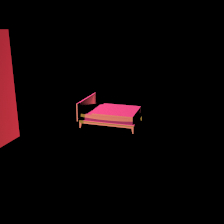

In [71]:
rendered_im